**APPENDIX J**

In [ ]:
!pip install keras-hypetune

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
 
import statsmodels.api as sm
 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
 
# Import Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy
import pandas
from matplotlib import pyplot 
from math import sqrt
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import seaborn as sns

In [ ]:

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from kerashypetune import KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
df = pd.read_csv('Aotizhongxin1 - Copy (3) - Copy.csv')
df['date'] = pd.to_datetime(df[['year','month','day','hour']])

In [ ]:
columns = ['DEWP','TEMP','PRES','RAIN','WSPM','PM10','SO2','NO2','CO','O3']

y_train = df[df.year < 2015]['PM2.5'].copy().values
train_date = df[df.year < 2015].date.values
x_train = df[df.year < 2015][columns].copy()

y_val = df[df.year == 2015]['PM2.5'].copy().values
val_date = df[df.year == 2015].date.values
x_val = df[df.year == 2015][columns].copy()

y_test = df[df.year == 2016]['PM2.5'].copy().values
test_date = df[df.year == 2016].date.values
x_test = df[df.year == 2016][columns].copy()

print(x_train.shape, x_val.shape, x_test.shape)


(16104, 10) (8760, 10) (8784, 10)


In [ ]:
sequence_length = 24*2

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
X_train, X_val, X_test = [], [], []

for sequence in gen_sequence(x_train, sequence_length, columns):
    X_train.append(sequence)
    
for sequence in gen_sequence(x_val, sequence_length, columns):
    X_val.append(sequence)
    
for sequence in gen_sequence(x_test, sequence_length, columns):
    X_test.append(sequence)
    
X_train, X_val, X_test = np.asarray(X_train), np.asarray(X_val), np.asarray(X_test)
print(X_train.shape, X_val.shape, X_test.shape)

(16056, 48, 10) (8712, 48, 10) (8736, 48, 10)


In [ ]:
def scale_target(y, mean, std):
    return (y - mean)/std

def reverse_target(pred, mean, std): 
    return pred*std + mean

In [ ]:
mean_train = y_train.mean()
std_train = y_train.std()

y_train_seq = scale_target(y_train[sequence_length:], mean_train, std_train)
y_val_seq = scale_target(y_val[sequence_length:], mean_train, std_train)
y_test_seq = scale_target(y_test[sequence_length:], mean_train, std_train)

print(y_train_seq.shape, y_val_seq.shape, y_test_seq.shape)

(16056,) (8712,) (8736,)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,len(columns))).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1,len(columns))).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1,len(columns))).reshape(X_test.shape)

In [ ]:
### DEFINE MODEL ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(params):
    
    set_seed(33)
    
    inp = Input(shape=(sequence_length, len(columns)))

    x = GRU(params['units_gru'], return_sequences=True)(inp)
    x = AveragePooling1D(2)(x)
    x = Conv1D(params['units_cnn'], 3, 
               activation='relu', padding='same', 
               name='extractor')(x)
    x = Flatten()(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=RMSprop(lr=params['lr']), loss='mse')
    
    return model

In [ ]:
param_grid = {
    'units_gru': [128, 64],
    'units_cnn': [64, 32],
    'lr': [1e-4, 1e-3],
    'batch_size': [512, 1024]
}

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
kgs = KerasGridSearch(get_model, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_seq, validation_data=(X_val, y_val_seq), callbacks=[es], epochs=50)


16 trials detected for ('units_gru', 'units_cnn', 'lr', 'batch_size')

***** (1/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.0001, 'batch_size': 512})
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
SCORE: 0.19664 at epoch 26

***** (2/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.0001, 'batch_size': 1024})
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
SCORE: 0.21678 at epoch 26

***** (3/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.001, 'batch_size': 512})
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
SCORE: 0.16552 at epoch 10

***** (4/16) *****
Search({'units_gru': 128, 'units_cnn': 64, 'lr': 0.001, 'batch_size': 1024})
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
SCORE: 0.16815 at epoch 12

***** (5/16) *****
Search({'units_gru': 128, 'units_cnn': 32, 'lr': 0.0001, 'batch_size': 512})


In [ ]:
### MAKE PREDICTION ON TEST ###

pred = reverse_target(kgs.best_model.predict([X_test]).ravel(), mean_train, std_train)

In [ ]:
pred.shape

(8736,)

In [ ]:
print(pred)

[414.65964 421.3863  460.90378 ... 335.72485 351.50964 365.03214]


In [ ]:
print(X_test)

[[[-1.02725147 -1.58172249  1.47376704 ...  1.67915843  4.09034541
   -0.66998862]
  [-0.95869474 -1.67389824  1.40336645 ...  1.56546842  4.18996796
   -0.61447045]
  [-0.95869474 -1.78450914  1.39330922 ...  1.45177841  3.09411986
   -0.68849468]
  ...
  [-0.74540712 -1.53563461  0.68930329 ...  4.03822608  6.08279649
   -0.65148256]
  [-0.74540712 -1.60937521  0.68930329 ...  4.3224511   6.58090926
   -0.66998862]
  [-0.70732005 -1.62781036  0.73958942 ...  4.09507108  6.08279649
   -0.68849468]]

 [[-0.95869474 -1.67389824  1.40336645 ...  1.56546842  4.18996796
   -0.61447045]
  [-0.95869474 -1.78450914  1.39330922 ...  1.45177841  3.09411986
   -0.68849468]
  [-0.9891644  -1.68311581  1.33296586 ...  1.33808841  2.89487476
   -0.74401285]
  ...
  [-0.74540712 -1.60937521  0.68930329 ...  4.3224511   6.58090926
   -0.66998862]
  [-0.70732005 -1.62781036  0.73958942 ...  4.09507108  6.08279649
   -0.68849468]
  [-0.70732005 -1.64624551  0.71947497 ...  4.03822608  6.48128671
   -0.

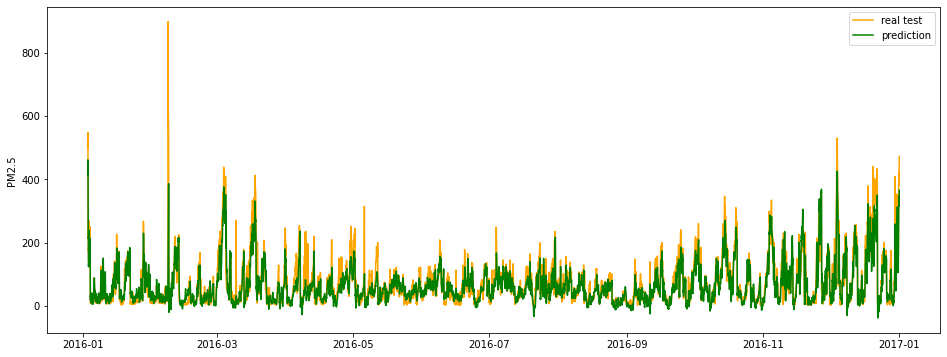

In [ ]:
### PREDICTIONS vs REALITY ON TEST ###

plt.figure(figsize=(16,6))

start, end = 0, 15000
plt.plot(test_date[sequence_length+start:end+sequence_length], y_test[sequence_length+start:end+sequence_length], 
         c='orange', label='real test')
plt.plot(test_date[sequence_length+start:end+sequence_length], pred[start:end], 
         c='green', label='prediction')
plt.legend(); plt.ylabel('PM2.5')
plt.show()





In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test[sequence_length+start:end+sequence_length],pred[start:end])))
print(mean_squared_error(y_test[sequence_length+start:end+sequence_length],pred[start:end]))
print(mean_absolute_error(y_test[sequence_length+start:end+sequence_length],pred[start:end]))
print(r2_score(y_test[sequence_length+start:end+sequence_length],pred[start:end]))


31.57951255607685
997.2656132794154
20.1486504239247
0.8265165159558724


In [ ]:
model.history

NameError: ignored

In [ ]:
### PREDICTIONS vs REALITY ON TEST ###



start, end = 0, 3000
print(mean_squared_error(test_date[sequence_length+start:end+sequence_length], y_test[sequence_length+start:end+sequence_length]))

        

In [ ]:
### PREDICTIONS vs REALITY ON TEST ###



start, end = 0, 3000
qqq =test_date[sequence_length+start:end+sequence_length]
www= y_test[sequence_length+start:end+sequence_length]

        

In [ ]:
qqq

In [ ]:
www

In [ ]:
print(test_date)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

print(mean_squared_error(pred, y_test_seq))

In [ ]:
### DEFINE MODEL ###


    
inp = Input(shape=(sequence_length, len(columns)))

x = GRU(128, return_sequences=True)(inp)
x = AveragePooling1D(2)(x)
x = Conv1D(64, 3,  activation='relu', padding='same', name='extractor')(x)
x = Flatten()(x)
out = Dense(1)(x)
    
model = Model(inp, out)
model.compile(optimizer=Adam(lr=0.01), loss='mse')
    

In [ ]:
df['2013-03-01']['PM2.5'].mean()

In [ ]:
df['PM2.5'].fillna(method='ffill', inplace=True)
df['PM2.5'].fillna(value=df['2013-03-01']['PM2.5'].mean(), inplace=True)
df.head()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

def plot_pred_date(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(train), columns=train.columns, index=train.index)
    
    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Predicted {col} vs DateTime')
        plt.show()
        
    return


def plot_actual_pred(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(valid), columns=valid.columns, index=valid.index)

    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Actual {col} vs Predicted {col}')
        plt.show()
        
    return

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]

In [ ]:
sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)

In [ ]:
n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam





lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(n_input, n_features)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu')))
lstm_model.add(tf.keras.layers.Dense(11))
lstm_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

lstm_model.summary()



In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i])))
    except Exception as err:
        print(i, err)

In [ ]:
plot_pred_date(lstm_pred)

In [ ]:
plot_actual_pred(lstm_pred)

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(11))
lstm_model.compile(RMSprop(lr=1e-06), loss='mse' )

lstm_model.summary()



In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i],  multioutput='variance_weighted')))
    except Exception as err:
        print(i, err)
   

In [ ]:
plot_pred_date(lstm_pred)

In [ ]:
plot_actual_pred(lstm_pred)

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(11))
lstm_model.compile(Adam(lr=1e-01), loss='mse' )

lstm_model.summary()



In [ ]:

history = lstm_model.fit_generator(generator,epochs=10)

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i],  multioutput='variance_weighted')))
    except Exception as err:
        print(i, err)
   

In [ ]:
plot_pred_date(lstm_pred)

In [ ]:
plot_actual_pred(lstm_pred)